# Doing inference with SageMaker Built-in Object Detection model

1. [Download the trained model artifact](#download)
1. [Convert training model to deployable model](#convert)
1. [Inference](#inference)
  1. [model load](#load)
  1. [single image inference](#singleinference)
  1. [batch inference](#batchinference)


## setup

In [1]:
%matplotlib inline

In [2]:
!pip install opencv-python
!pip install gluoncv

    100% |████████████████████████████████| 26.6MB 1.1MB/s eta 0:00:01
You are using pip version 10.0.1, however version 19.2.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |████████████████████████████████| 348kB 28.6MB/s ta 0:00:01
    100% |████████████████████████████████| 51kB 25.0MB/s ta 0:00:01
You are using pip version 10.0.1, however version 19.2.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
from matplotlib import pyplot as plt
from gluoncv.utils import download, viz
import numpy as np
import mxnet as mx
import json
import boto3
import cv2

# Download the trained model artifact <a id='download'></a>


In [ ]:
JOB_ID='<please replace with your training job name>' 
S3_OUTPUT_BUCKET = '<please replace with your s3 bucket name>'

In [16]:
JOB_ID='od-test-copy-07-31-no-aug'  
S3_OUTPUT_BUCKET = 'angelaw-test-sagemaker-blog'

In [7]:
sagemaker_client =  boto3.client('sagemaker')
MODEL_ARTIFACT = sagemaker_client.describe_training_job(TrainingJobName=JOB_ID)['ModelArtifacts']['S3ModelArtifacts']
MODEL_ARTIFACT

u's3://angelaw-test-sagemaker-blog/demo/output/od-test-copy-07-31-no-aug/output/model.tar.gz'

In [8]:
import os 

def make_tmp_folder(folder_name):
    try:
        os.makedirs(folder_name)
    except OSError as e:
        print("{} folder already exists".format(folder_name))

In [9]:
TMP_FOLDER = 'trained-model'
make_tmp_folder(TMP_FOLDER)

!aws s3 cp $MODEL_ARTIFACT $TMP_FOLDER/.

download: s3://angelaw-test-sagemaker-blog/demo/output/od-test-copy-07-31-no-aug/output/model.tar.gz to trained-model/model.tar.gz


In [10]:
!tar -xvzf $TMP_FOLDER/model.tar.gz -C $TMP_FOLDER/

model_algo_1-symbol.json
hyperparams.json
model_algo_1-0000.params


# Convert the training model to a deployable model <a id='convert'></a>

Make sure to clone this Git repo to your ~/SageMaker folder

```
cd ~/SageMaker
git clone https://github.com/zhreshold/mxnet-ssd.git
```

In [12]:
%%sh
cd ~/SageMaker
git clone https://github.com/zhreshold/mxnet-ssd.git

Cloning into 'mxnet-ssd'...


In [13]:
!python /home/ec2-user/SageMaker/mxnet-ssd/deploy.py -h

Using mxnet as:
<module 'mxnet' from '/home/ec2-user/anaconda3/envs/mxnet_p27/lib/python2.7/site-packages/mxnet/__init__.pyc'>
(export MXNET_EXAMPLE_SSD_DISABLE_PRE_INSTALLED=1) to prevent loading pre-installed mxnet.
usage: deploy.py [-h] [--network NETWORK] [--epoch EPOCH] [--prefix PREFIX]
                 [--data-shape DATA_SHAPE] [--num-class NUM_CLASSES]
                 [--nms NMS_THRESH] [--force FORCE_NMS] [--topk NMS_TOPK]

Convert a trained model to deploy model

optional arguments:
  -h, --help            show this help message and exit
  --network NETWORK     which network to use
  --epoch EPOCH         epoch of trained model
  --prefix PREFIX       trained model prefix
  --data-shape DATA_SHAPE
                        data shape
  --num-class NUM_CLASSES
                        number of classes
  --nms NMS_THRESH      non-maximum suppression threshold, default 0.5
  --force FORCE_NMS     force non-maximum suppression on different class
  --topk NMS_TOPK       apply nms o

In [14]:
!python /home/ec2-user/SageMaker/mxnet-ssd/deploy.py --network resnet50 --num-class 2 --nms .45 --data-shape 512 --prefix $TMP_FOLDER/model_algo_1

Using mxnet as:
<module 'mxnet' from '/home/ec2-user/anaconda3/envs/mxnet_p27/lib/python2.7/site-packages/mxnet/__init__.pyc'>
(export MXNET_EXAMPLE_SSD_DISABLE_PRE_INSTALLED=1) to prevent loading pre-installed mxnet.
Saved model: trained-model/deploy_model_algo_1-0000.params
Saved symbol: trained-model/deploy_model_algo_1-symbol.json


In [15]:
!ls -alh $TMP_FOLDER

total 308M
drwxrwxr-x 2 ec2-user ec2-user 4.0K Aug  1 18:02 .
drwxrwxr-x 6 ec2-user ec2-user 4.0K Aug  1 18:02 ..
-rw-rw-r-- 1 ec2-user ec2-user 106M Aug  1 18:02 deploy_model_algo_1-0000.params
-rw-rw-r-- 1 ec2-user ec2-user 129K Aug  1 18:02 deploy_model_algo_1-symbol.json
-rw-r--r-- 1 ec2-user ec2-user  683 Aug  1 04:30 hyperparams.json
-rw-r--r-- 1 ec2-user ec2-user 106M Aug  1 04:30 model_algo_1-0000.params
-rw-r--r-- 1 ec2-user ec2-user 130K Aug  1 04:30 model_algo_1-symbol.json
-rw-rw-r-- 1 ec2-user ec2-user  98M Aug  1 04:31 model.tar.gz


In [17]:
!aws s3 cp $TMP_FOLDER/deploy_model_algo_1-0000.params s3://$S3_OUTPUT_BUCKET/deployable-model/
!aws s3 cp $TMP_FOLDER/deploy_model_algo_1-symbol.json s3://$S3_OUTPUT_BUCKET/deployable-model/

upload: trained-model/deploy_model_algo_1-0000.params to s3://angelaw-test-sagemaker-blog/deployable-model/deploy_model_algo_1-0000.params
upload: trained-model/deploy_model_algo_1-symbol.json to s3://angelaw-test-sagemaker-blog/deployable-model/deploy_model_algo_1-symbol.json


# Doing inference with the model on local host <a id='inference'></a>

Below code will run inference on a set of test images on the current notebook instance. Using a GPU instance (e.g. p2.*, p3.* family) will result in faster performance than CPU only instances

In [32]:
def get_ctx():
    try:
        gpus = mx.test_utils.list_gpus()
        if len(gpus) > 0:
            ctx = []
            for gpu in gpus:
                ctx.append(mx.gpu(gpu))
        else:
            ctx = [mx.cpu()]
    except:
        ctx = [mx.cpu()]
    return ctx

ctx = get_ctx()[0]
ctx

cpu(0)

In [21]:
SHAPE = 512
input_shapes=[('data', (1, 3, SHAPE, SHAPE))]
confidence_threshold = 0.3
CLASSES = ['blue box', 'yellow box']


## loading the model <a id="load"> </a>

In [22]:
%%time

param_path=os.path.join(TMP_FOLDER, 'deploy_model_algo_1')
print("param_path: {}".format(param_path))
sym, arg_params, aux_params = mx.model.load_checkpoint(param_path, 0)
mod = mx.mod.Module(symbol=sym, label_names=[], context=ctx)
mod.bind(for_training=False, data_shapes=input_shapes)
mod.set_params(arg_params, aux_params)

param_path: trained-model/deploy_model_algo_1
CPU times: user 89.5 ms, sys: 111 ms, total: 201 ms
Wall time: 152 ms


In [23]:
from collections import namedtuple
Batch = namedtuple('Batch', ['data'])

def predict_from_file(filepath, reshape=(SHAPE, SHAPE)):
    # Switch RGB to BGR format (which ImageNet networks take)
    img = cv2.cvtColor(cv2.imread(filepath), cv2.COLOR_BGR2RGB)
    if img is None:
        return []

     # Resize image to fit network input
    img = cv2.resize(img, reshape)
    
    org_image = img.copy()
    img = np.swapaxes(img, 0, 2)
    img = np.swapaxes(img, 1, 2)
    img = img[np.newaxis, :]
 
    mod.forward(Batch([mx.nd.array(img)]))
    prob = mod.get_outputs()[0].asnumpy()
    prob = np.squeeze(prob)

    return prob, org_image

In [24]:
def infer(image_path, threshold=confidence_threshold):
    results, org_image = predict_from_file(image_path)
    image_name = image_path.split("/")[-1]
    
    filtered_result = results[results[:, 0] != -1]
    filtered_result = filtered_result[filtered_result[:, 1] >=threshold]
    
    return filtered_result, org_image

## Test inference on single image <a id="singleinference"></a>

In [25]:
!aws s3 cp s3://greengrass-object-detection-blog/frames/validation_box_video/validation_box_video_000298.jpg .

download: s3://greengrass-object-detection-blog/frames/validation_box_video/validation_box_video_000298.jpg to ./validation_box_video_000298.jpg


In [26]:
%%time

prediction_image = 'validation_box_video_000298.jpg'
results, org_image = infer(prediction_image)

CPU times: user 1.01 s, sys: 64.7 ms, total: 1.08 s
Wall time: 1.2 s


In [27]:
results[:, (2, 4)] *= SHAPE
results[:, (3, 5)] *= SHAPE

In [28]:
org_image.shape

(512, 512, 3)

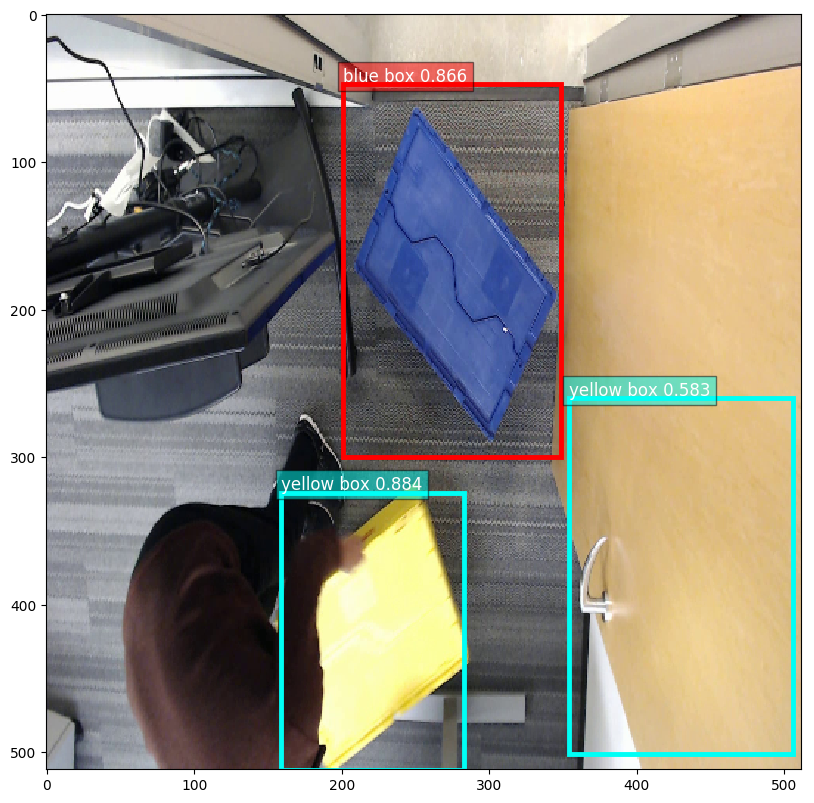

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 10), facecolor='white', dpi=100)
axis=axes

ax = viz.plot_bbox(org_image, results[:,-4:], results[:,1], results[:,0],thresh=0.1, class_names=CLASSES, ax=axis)

## Run inference on a data set <a id="singleinference"></a>

In [34]:
VALIDATION_IMAGE_FOLDER = 'validation'
make_tmp_folder(VALIDATION_IMAGE_FOLDER)

In [37]:
!aws s3 sync s3://greengrass-object-detection-blog/frames/validation_box_video/ $VALIDATION_IMAGE_FOLDER/ --quiet

In [38]:
!ls -1 $VALIDATION_IMAGE_FOLDER/ | wc -l

469


In [ ]:
%%time 

img_list = os.listdir(VALIDATION_IMAGE_FOLDER)

output_file = 'validation-inference-results.json'
with open(output_file, "w") as outfile:
    for img in img_list:
        if img.endswith("jpg"):
            result,_orig = infer(os.path.join(VALIDATION_IMAGE_FOLDER, img))
            to_write = {"image": img, "prediction": result.tolist()}
            outfile.write(json.dumps(to_write))
            outfile.write('\n')

In [ ]:
!head $output_file


In [ ]:
visualization_pdf_name = 'validation-visualization.pdf'

In [ ]:
!python ./07_visualize_prediction_labels_batch.py -i $VALIDATION_IMAGE_FOLDER -l $output_file -f $visualization_pdf_name -c $confidence_threshold

In [ ]:
!aws s3 cp $visualization_pdf_name s3://$S3_OUTPUT_BUCKET/prediction-visualization/